## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [ ]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Mounted at /content/drive


Importing required libraries

In [ ]:
import os, gc
import shutil
import time, datetime
from thop import profile, clever_format
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [ ]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


In [ ]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
assert False, "Stop execution of next cell!"

AssertionError: Stop execution of next cell!

## Single Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_caps_layers=1
n_class=10
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter1_capsnet_cifar10_model.name = 'multilayer_inter1_capsnet_cifar10_model'
multilayer_inter1_capsnet_cifar10_model = multilayer_inter1_capsnet_cifar10_model.to(device)
multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_37pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_37pc_base_capsnet_cifar10_model = pruned_37pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_37p_multilayer_inter1_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter1_capsnet_cifar10_model,
        saved_state_dict=pruned_37pc_base_capsnet_cifar10_model,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_37p_multilayer_inter1_capsnet_cifar10_model.name = 'pruned_37p_multilayer_inter1_capsnet_cifar10_model'
pruned_37p_multilayer_inter1_capsnet_cifar10_model=pruned_37p_multilayer_inter1_capsnet_cifar10_model.to(device)
pruned_37p_multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
%%time
best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_37p_multilayer_inter1_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/26 02:42:25 PM | pruned_37p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7030, Top 1 Acc=18.75, Top 5 Acc=46.88
INFO:capsnet:pruned_37p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7030, Top 1 Acc=18.75, Top 5 Acc=46.88
01/26 02:42:28 PM | pruned_37p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6380, Top 1 Acc=19.60, Top 5 Acc=60.98
INFO:capsnet:pruned_37p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6380, Top 1 Acc=19.60, Top 5 Acc=60.98
01/26 02:42:31 PM | pruned_37p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5454, Top 1 Acc=27.55, Top 5 Acc=71.83
INFO:capsnet:pruned_37p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5454, Top 1 Acc=27.55, Top 5 Acc=71.83
01/26 02:42:34 PM | pruned_37p_multilayer_inter1_capsnet_cifar10_model Trai

CPU times: user 35min 33s, sys: 2min 38s, total: 38min 12s
Wall time: 38min 36s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter1_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

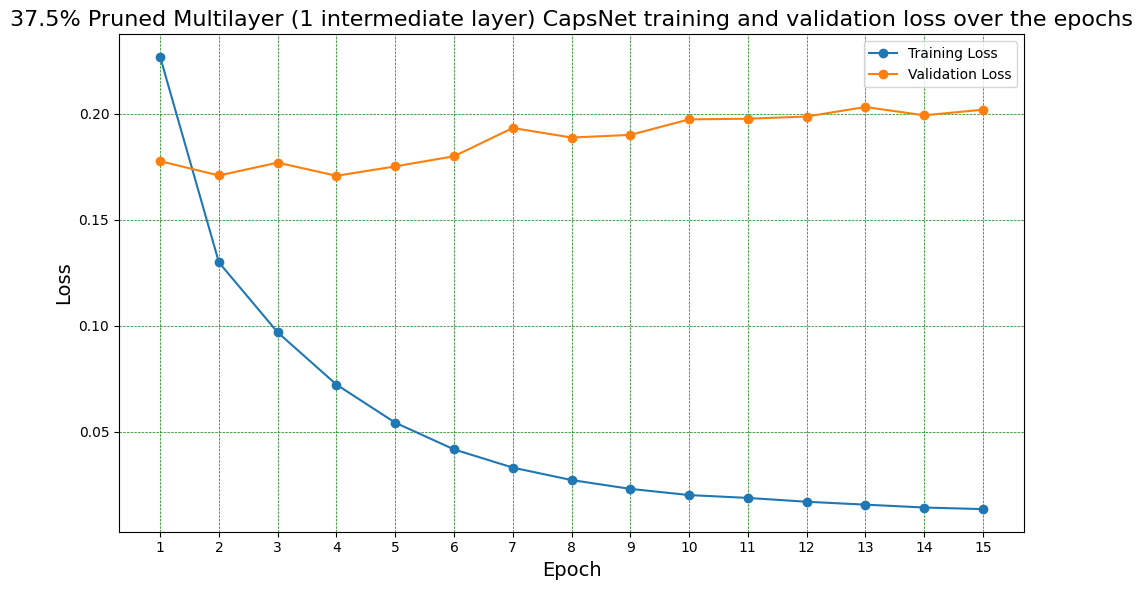

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% Pruned Multilayer (1 intermediate layer) CapsNet training and validation loss over the epochs')

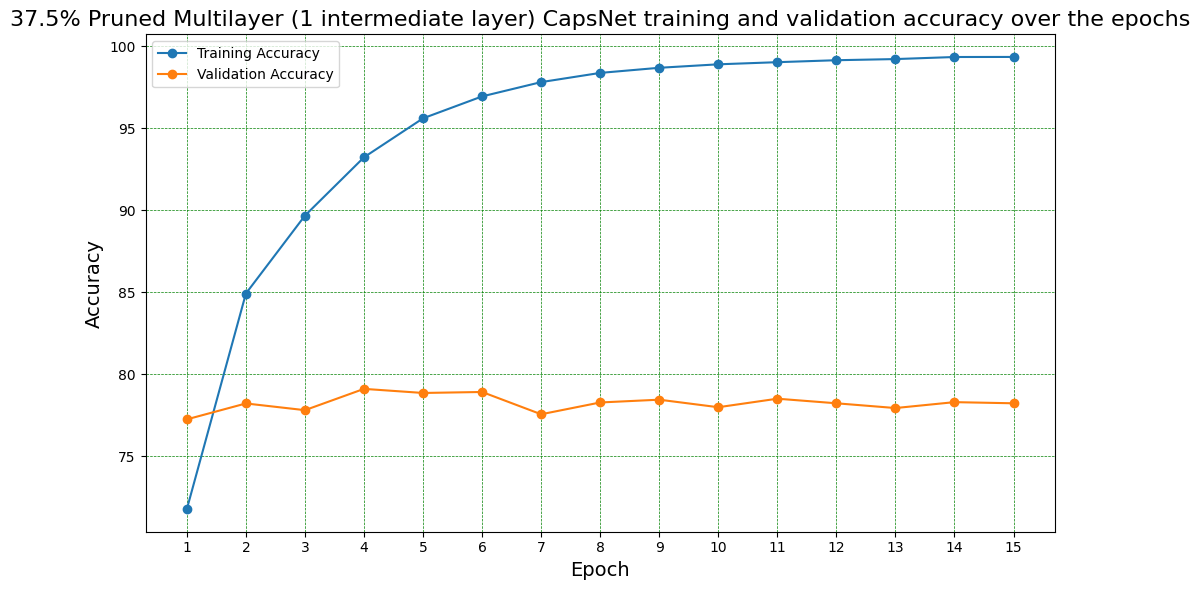

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% Pruned Multilayer (1 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 2 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_caps_layers=1
n_class=10
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter2_capsnet_cifar10_model.name = 'multilayer_inter2_capsnet_cifar10_model'
multilayer_inter2_capsnet_cifar10_model = multilayer_inter2_capsnet_cifar10_model.to(device)
multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAgg

In [ ]:
pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_37pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_37pc_base_capsnet_cifar10_model = pruned_37pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_37p_multilayer_inter2_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter2_capsnet_cifar10_model,
        saved_state_dict=pruned_37pc_base_capsnet_cifar10_model,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_37p_multilayer_inter2_capsnet_cifar10_model.name = 'pruned_37p_multilayer_inter2_capsnet_cifar10_model'
pruned_37p_multilayer_inter2_capsnet_cifar10_model=pruned_37p_multilayer_inter2_capsnet_cifar10_model.to(device)
pruned_37p_multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
%%time
best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_37p_multilayer_inter2_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/26 03:24:41 PM | pruned_37p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7131, Top 1 Acc=3.12, Top 5 Acc=50.00
INFO:capsnet:pruned_37p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7131, Top 1 Acc=3.12, Top 5 Acc=50.00
01/26 03:24:45 PM | pruned_37p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6669, Top 1 Acc=15.91, Top 5 Acc=60.23
INFO:capsnet:pruned_37p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6669, Top 1 Acc=15.91, Top 5 Acc=60.23
01/26 03:24:50 PM | pruned_37p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5853, Top 1 Acc=21.54, Top 5 Acc=68.85
INFO:capsnet:pruned_37p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5853, Top 1 Acc=21.54, Top 5 Acc=68.85
01/26 03:24:54 PM | pruned_37p_multilayer_inter2_capsnet_cifar10_model Traini

CPU times: user 48min 29s, sys: 3min 33s, total: 52min 3s
Wall time: 52min 35s


In [ ]:
# from google.colab import runtime
# runtime.unassign()

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

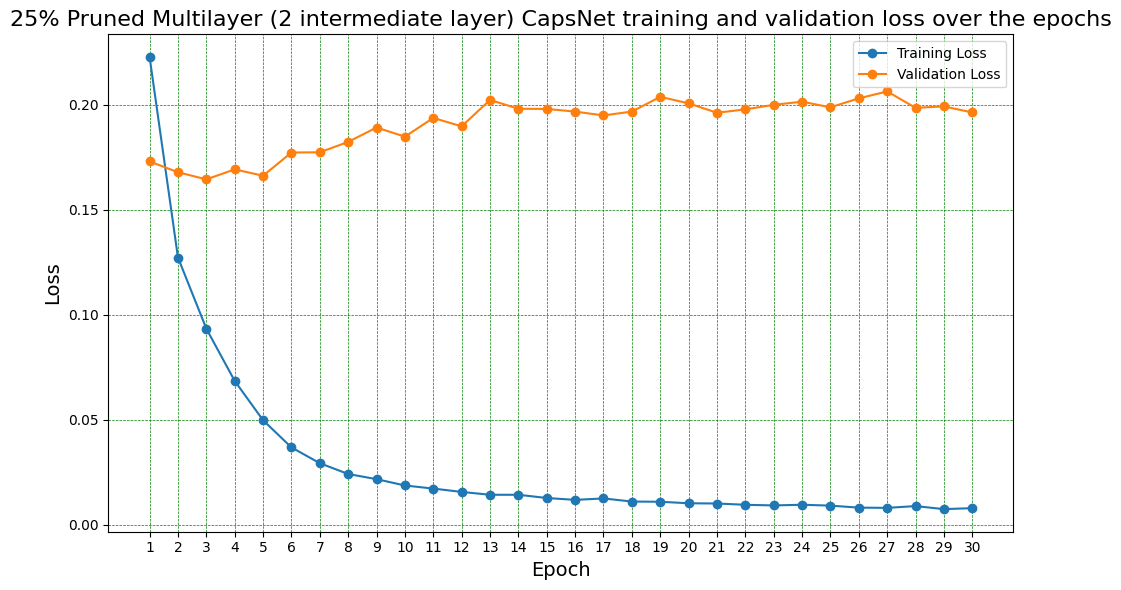

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% Pruned Multilayer (2 intermediate layer) CapsNet training and validation loss over the epochs')

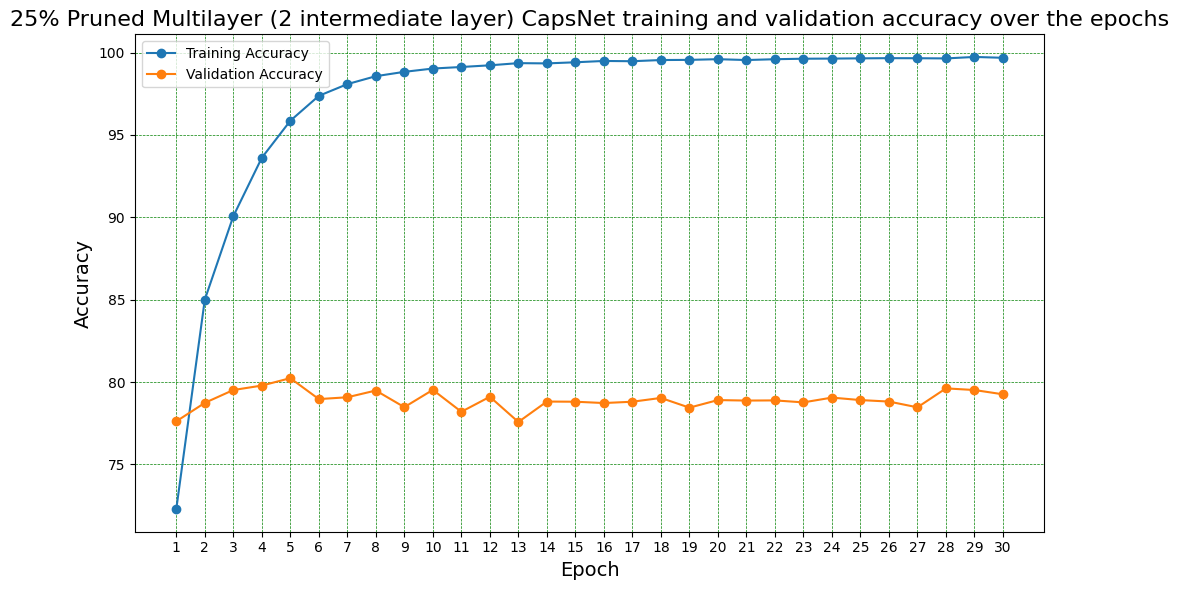

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% Pruned Multilayer (2 intermediate layer) CapsNet training and validation accuracy over the epochs')

In [ ]:
from google.colab import runtime
runtime.unassign()

## 3 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=3

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:05<00:00, 29324315.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter3_capsnet_cifar10_model.name = 'multilayer_inter3_capsnet_cifar10_model'
multilayer_inter3_capsnet_cifar10_model = multilayer_inter3_capsnet_cifar10_model.to(device)
multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
 

In [ ]:
pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_37pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_37pc_base_capsnet_cifar10_model = pruned_37pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_37p_multilayer_inter3_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter3_capsnet_cifar10_model,
        saved_state_dict=pruned_37pc_base_capsnet_cifar10_model,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_37p_multilayer_inter3_capsnet_cifar10_model.name = 'pruned_37p_multilayer_inter3_capsnet_cifar10_model'
pruned_37p_multilayer_inter3_capsnet_cifar10_model=pruned_37p_multilayer_inter3_capsnet_cifar10_model.to(device)
pruned_37p_multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
  (class_caps): 

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_37p_multilayer_inter3_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/27 08:04:19 PM | pruned_37p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7053, Top 1 Acc=6.25, Top 5 Acc=46.88
INFO:capsnet:pruned_37p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7053, Top 1 Acc=6.25, Top 5 Acc=46.88
01/27 08:04:27 PM | pruned_37p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6708, Top 1 Acc=14.39, Top 5 Acc=56.82
INFO:capsnet:pruned_37p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6708, Top 1 Acc=14.39, Top 5 Acc=56.82
01/27 08:04:32 PM | pruned_37p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5904, Top 1 Acc=22.26, Top 5 Acc=67.26
INFO:capsnet:pruned_37p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5904, Top 1 Acc=22.26, Top 5 Acc=67.26
01/27 08:04:37 PM | pruned_37p_multilayer_inter3_capsnet_cifar10_model Traini

CPU times: user 1h 50s, sys: 4min 34s, total: 1h 5min 24s
Wall time: 1h 6min 12s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

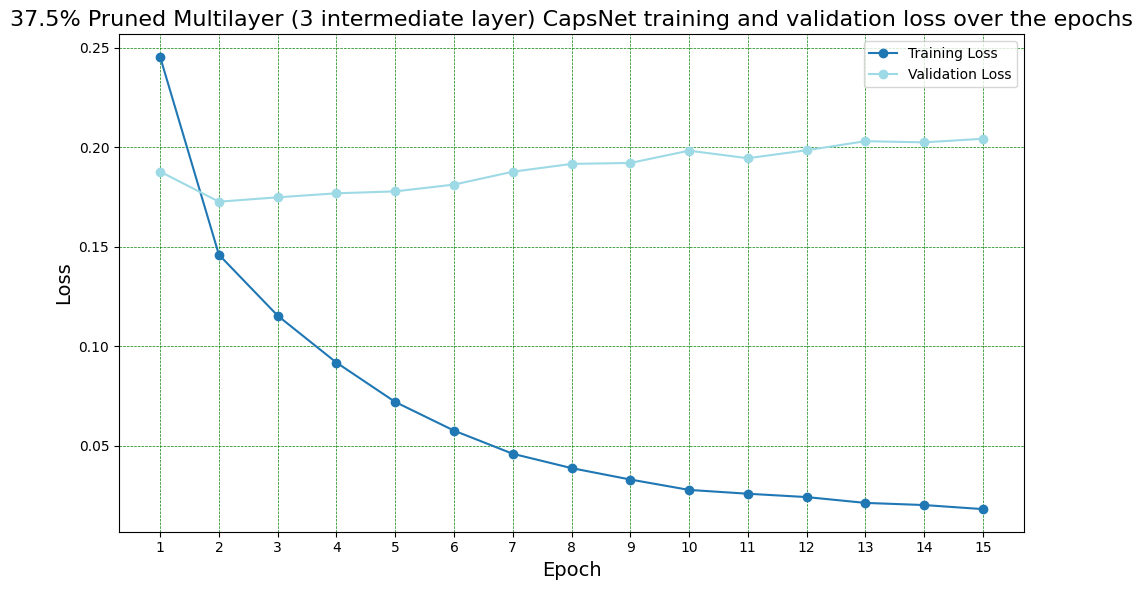

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% Pruned Multilayer (3 intermediate layer) CapsNet training and validation loss over the epochs')

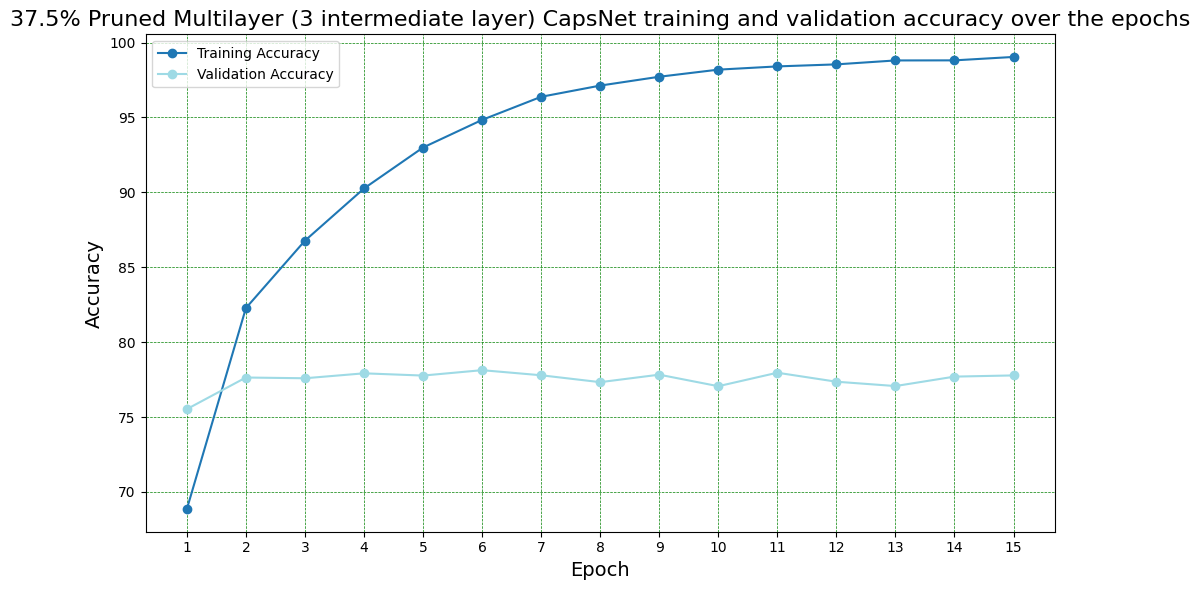

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% Pruned Multilayer (3 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 4 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=4

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter4_capsnet_cifar10_model.name = 'multilayer_inter4_capsnet_cifar10_model'
multilayer_inter4_capsnet_cifar10_model = multilayer_inter4_capsnet_cifar10_model.to(device)
multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_37pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_37pc_base_capsnet_model_state_dict = pruned_37pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_37p_multilayer_inter4_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter4_capsnet_cifar10_model,
        saved_state_dict=pruned_37pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_37p_multilayer_inter4_capsnet_cifar10_model.name = 'pruned_37p_multilayer_inter4_capsnet_cifar10_model'
pruned_37p_multilayer_inter4_capsnet_cifar10_model = pruned_37p_multilayer_inter4_capsnet_cifar10_model.to(device)
pruned_37p_multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_37p_multilayer_inter4_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/27 09:25:37 PM | pruned_37p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7064, Top 1 Acc=9.38, Top 5 Acc=53.12
INFO:capsnet:pruned_37p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7064, Top 1 Acc=9.38, Top 5 Acc=53.12
01/27 09:25:43 PM | pruned_37p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6885, Top 1 Acc=14.87, Top 5 Acc=56.44
INFO:capsnet:pruned_37p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6885, Top 1 Acc=14.87, Top 5 Acc=56.44
01/27 09:25:50 PM | pruned_37p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6440, Top 1 Acc=19.52, Top 5 Acc=63.08
INFO:capsnet:pruned_37p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6440, Top 1 Acc=19.52, Top 5 Acc=63.08
01/27 09:25:56 PM | pruned_37p_multilayer_inter4_capsnet_cifar10_model Traini

CPU times: user 1h 15min 48s, sys: 5min 33s, total: 1h 21min 22s
Wall time: 1h 22min 13s


Checkpoint restart

In [ ]:
%%time
n_epochs = 30

checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt'

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_37p_multilayer_inter4_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device,
                                                                checkpoint_file=checkpoint_file)

01/26 12:51:57 AM | pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.0079, Top 1 Acc=100.00, Top 5 Acc=100.00
INFO:capsnet:pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.0079, Top 1 Acc=100.00, Top 5 Acc=100.00
01/26 12:52:04 AM | pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.0142, Top 1 Acc=99.24, Top 5 Acc=99.72
INFO:capsnet:pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.0142, Top 1 Acc=99.24, Top 5 Acc=99.72
01/26 12:52:10 AM | pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.0144, Top 1 Acc=99.09, Top 5 Acc=99.86
INFO:capsnet:pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.0144, Top 1 Acc=99.09, Top 5 Acc=99.86
01/26 12:52:17 AM | pruned_25p_multilayer_inter4_capsnet_cifar10_

CPU times: user 1h 19min 59s, sys: 5min 3s, total: 1h 25min 2s
Wall time: 1h 24min 50s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

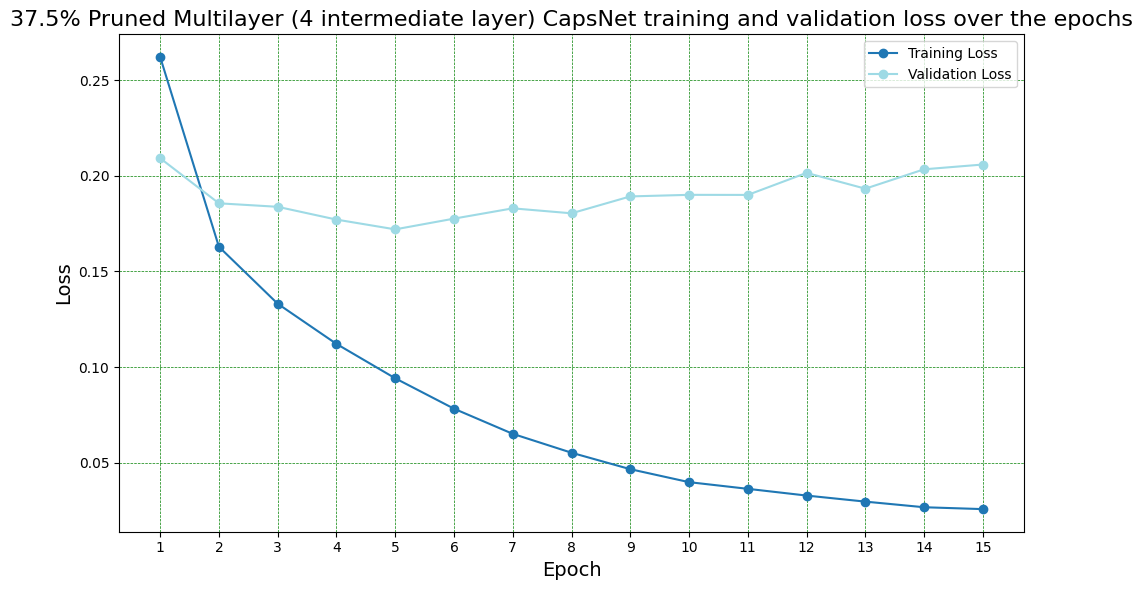

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% Pruned Multilayer (4 intermediate layer) CapsNet training and validation loss over the epochs')

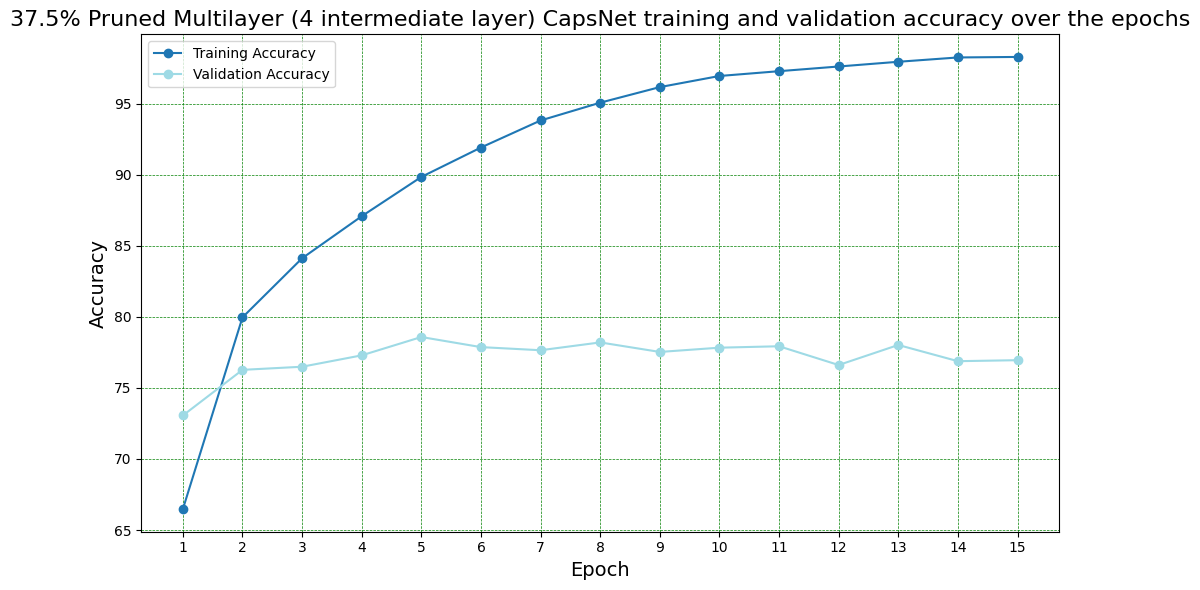

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% Pruned Multilayer (4 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 5 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=5

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter5_capsnet_cifar10_model.name = 'multilayer_inter5_capsnet_cifar10_model'
multilayer_inter5_capsnet_cifar10_model = multilayer_inter5_capsnet_cifar10_model.to(device)
multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_37pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_37pc_base_capsnet_model_state_dict = pruned_37pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_37p_multilayer_inter5_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter5_capsnet_cifar10_model,
        saved_state_dict=pruned_37pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_37p_multilayer_inter5_capsnet_cifar10_model.name = 'pruned_37p_multilayer_inter5_capsnet_cifar10_model'
pruned_37p_multilayer_inter5_capsnet_cifar10_model = pruned_37p_multilayer_inter5_capsnet_cifar10_model.to(device)
pruned_37p_multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_37p_multilayer_inter5_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/27 10:57:45 PM | pruned_37p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7017, Top 1 Acc=9.38, Top 5 Acc=56.25
INFO:capsnet:pruned_37p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7017, Top 1 Acc=9.38, Top 5 Acc=56.25
01/27 10:57:53 PM | pruned_37p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6957, Top 1 Acc=12.03, Top 5 Acc=53.60
INFO:capsnet:pruned_37p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6957, Top 1 Acc=12.03, Top 5 Acc=53.60
01/27 10:58:01 PM | pruned_37p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6699, Top 1 Acc=15.67, Top 5 Acc=59.52
INFO:capsnet:pruned_37p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6699, Top 1 Acc=15.67, Top 5 Acc=59.52
01/27 10:58:09 PM | pruned_37p_multilayer_inter5_capsnet_cifar10_model Traini

CPU times: user 1h 31min 13s, sys: 6min 39s, total: 1h 37min 52s
Wall time: 1h 38min 52s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter5_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

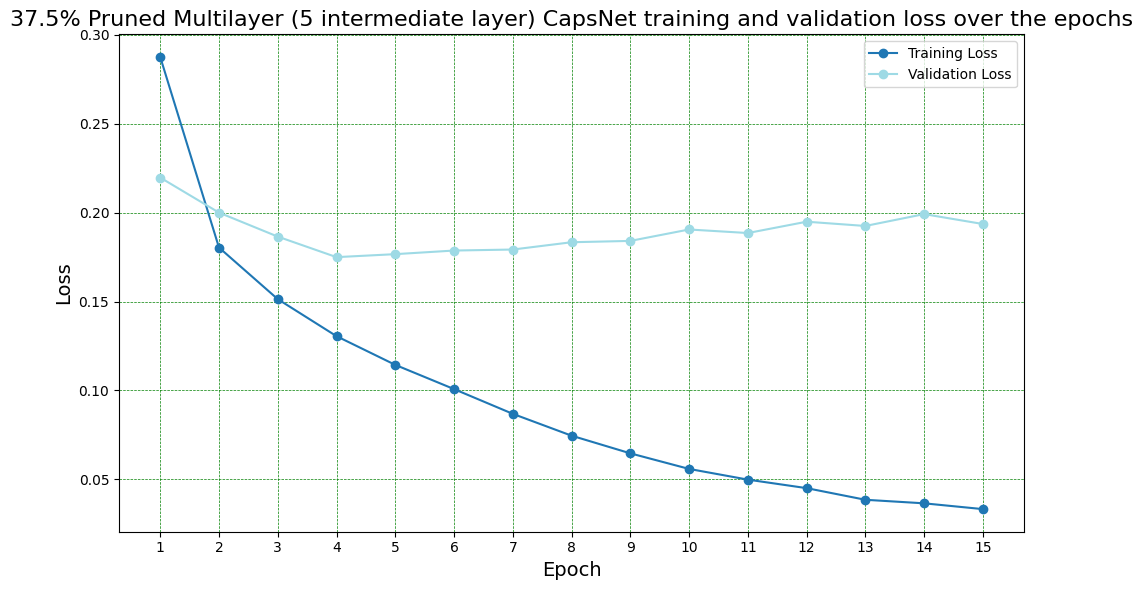

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% Pruned Multilayer (5 intermediate layer) CapsNet training and validation loss over the epochs')

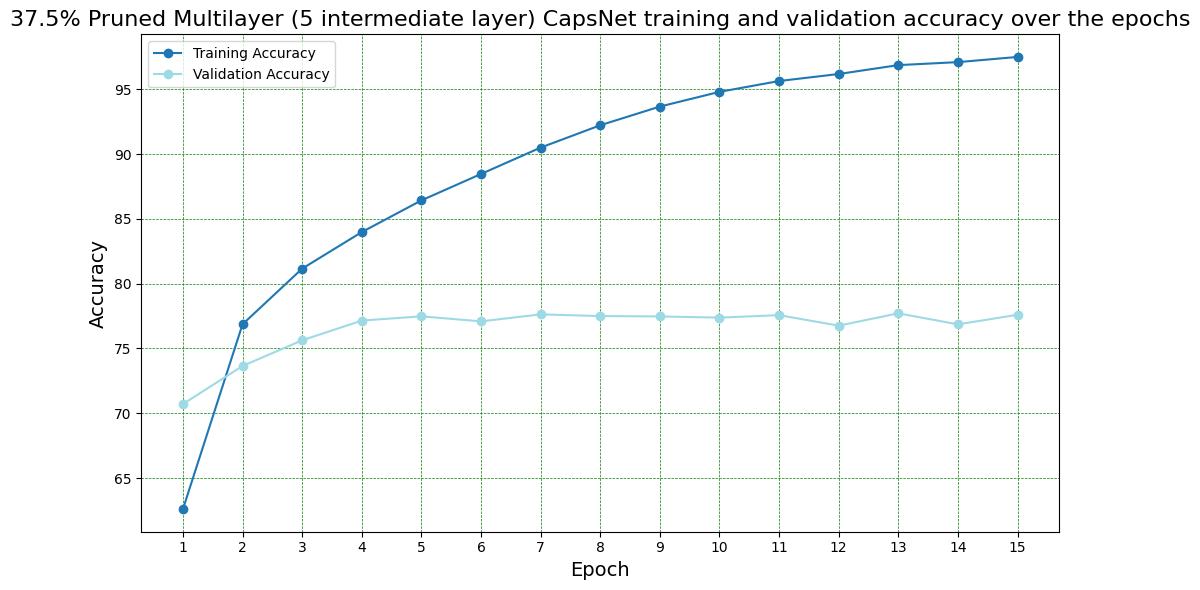

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% Pruned Multilayer (5 intermediate layer) CapsNet training and validation accuracy over the epochs')

In [ ]:
# from google.colab import runtime
# runtime.unassign()

## 6 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=6

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:05<00:00, 29450628.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter6_capsnet_cifar10_model.name = 'multilayer_inter6_capsnet_cifar10_model'
multilayer_inter6_capsnet_cifar10_model = multilayer_inter6_capsnet_cifar10_model.to(device)
multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_37pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_37pc_base_capsnet_model_state_dict = pruned_37pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_37p_multilayer_inter6_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter6_capsnet_cifar10_model,
        saved_state_dict=pruned_37pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_37p_multilayer_inter6_capsnet_cifar10_model.name = 'pruned_37p_multilayer_inter6_capsnet_cifar10_model'
pruned_37p_multilayer_inter6_capsnet_cifar10_model = pruned_37p_multilayer_inter6_capsnet_cifar10_model.to(device)
pruned_37p_multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_37p_multilayer_inter6_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/28 12:59:04 AM | pruned_37p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.6950, Top 1 Acc=25.00, Top 5 Acc=56.25
INFO:capsnet:pruned_37p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.6950, Top 1 Acc=25.00, Top 5 Acc=56.25
01/28 12:59:14 AM | pruned_37p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6988, Top 1 Acc=11.17, Top 5 Acc=50.57
INFO:capsnet:pruned_37p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6988, Top 1 Acc=11.17, Top 5 Acc=50.57
01/28 12:59:23 AM | pruned_37p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6858, Top 1 Acc=13.85, Top 5 Acc=55.43
INFO:capsnet:pruned_37p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6858, Top 1 Acc=13.85, Top 5 Acc=55.43
01/28 12:59:32 AM | pruned_37p_multilayer_inter6_capsnet_cifar10_model Trai

Checkpoint Restart

In [ ]:
%%time
n_epochs = 15
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt'

best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_37p_multilayer_inter6_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device,
                                                  checkpoint_file=checkpoint_file)

01/28 03:20:48 AM | pruned_37p_multilayer_inter6_capsnet_cifar10_model best accuracy=77.990 saved at: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_pruned_37p_multilayer_inter6_capsnet_cifar10_model_Epoch13_of_15.pt
INFO:capsnet:pruned_37p_multilayer_inter6_capsnet_cifar10_model best accuracy=77.990 saved at: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_pruned_37p_multilayer_inter6_capsnet_cifar10_model_Epoch13_of_15.pt


CPU times: user 54.3 ms, sys: 36.5 ms, total: 90.8 ms
Wall time: 3.16 s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

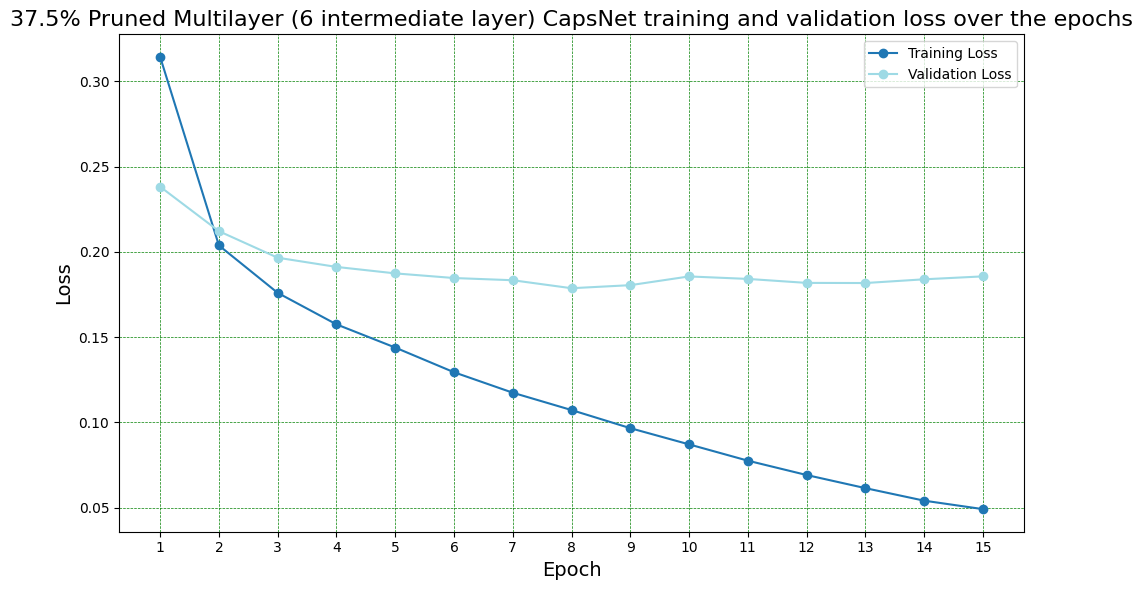

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% Pruned Multilayer (6 intermediate layer) CapsNet training and validation loss over the epochs')

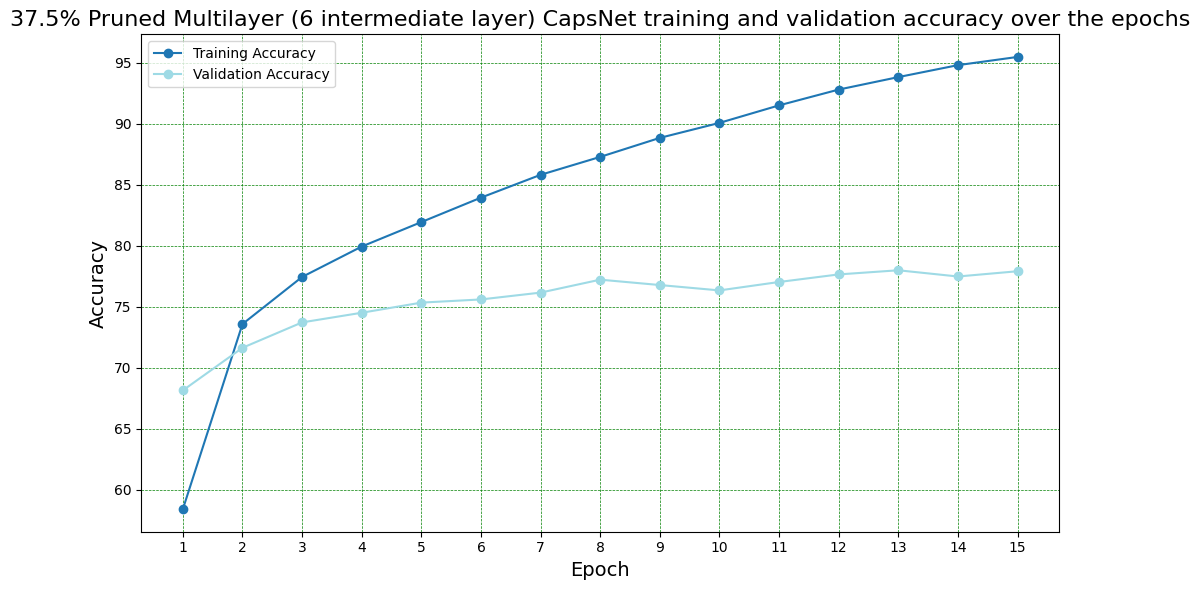

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% Pruned Multilayer (6 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 7 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=7

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:12<00:00, 13140118.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter7_capsnet_cifar10_model.name = 'multilayer_inter7_capsnet_cifar10_model'
multilayer_inter7_capsnet_cifar10_model = multilayer_inter7_capsnet_cifar10_model.to(device)
multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_37pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_37pc_base_capsnet_model_state_dict = pruned_37pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_37p_multilayer_inter7_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter7_capsnet_cifar10_model,
        saved_state_dict=pruned_37pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_37p_multilayer_inter7_capsnet_cifar10_model.name = 'pruned_37p_multilayer_inter7_capsnet_cifar10_model'
pruned_37p_multilayer_inter7_capsnet_cifar10_model = pruned_37p_multilayer_inter7_capsnet_cifar10_model.to(device)
pruned_37p_multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_37p_multilayer_inter7_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/28 02:15:04 PM | pruned_37p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7198, Top 1 Acc=0.00, Top 5 Acc=37.50
INFO:capsnet:pruned_37p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7198, Top 1 Acc=0.00, Top 5 Acc=37.50
01/28 02:15:13 PM | pruned_37p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6990, Top 1 Acc=11.55, Top 5 Acc=52.18
INFO:capsnet:pruned_37p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6990, Top 1 Acc=11.55, Top 5 Acc=52.18
01/28 02:15:21 PM | pruned_37p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6920, Top 1 Acc=12.02, Top 5 Acc=53.94
INFO:capsnet:pruned_37p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6920, Top 1 Acc=12.02, Top 5 Acc=53.94
01/28 02:15:29 PM | pruned_37p_multilayer_inter7_capsnet_cifar10_model Traini

CPU times: user 1h 36min 11s, sys: 7min 45s, total: 1h 43min 56s
Wall time: 1h 43min 43s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

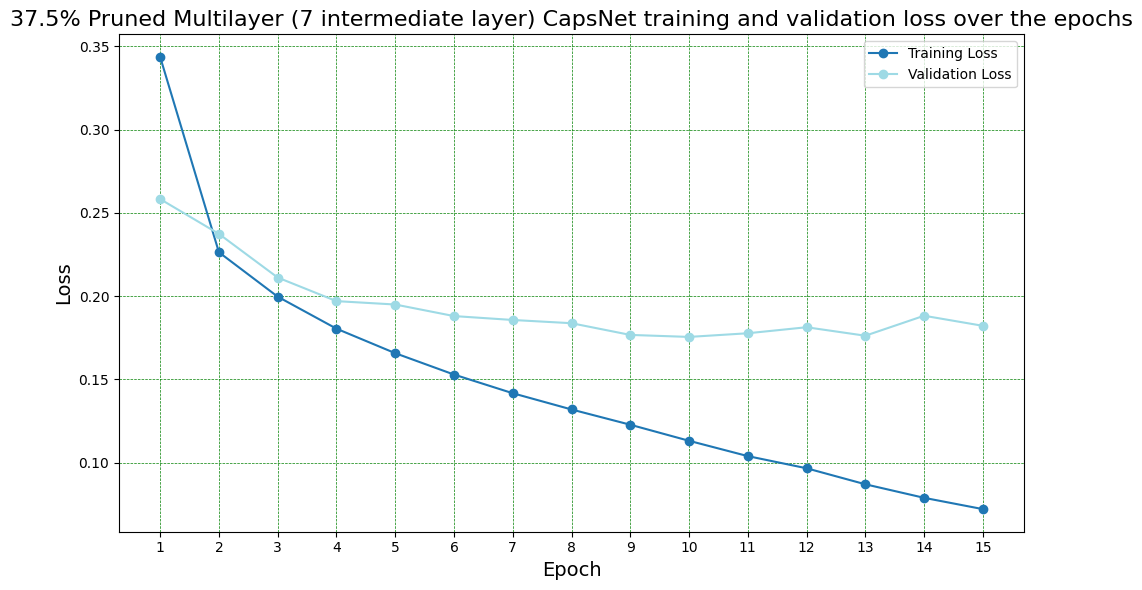

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% Pruned Multilayer (7 intermediate layer) CapsNet training and validation loss over the epochs')

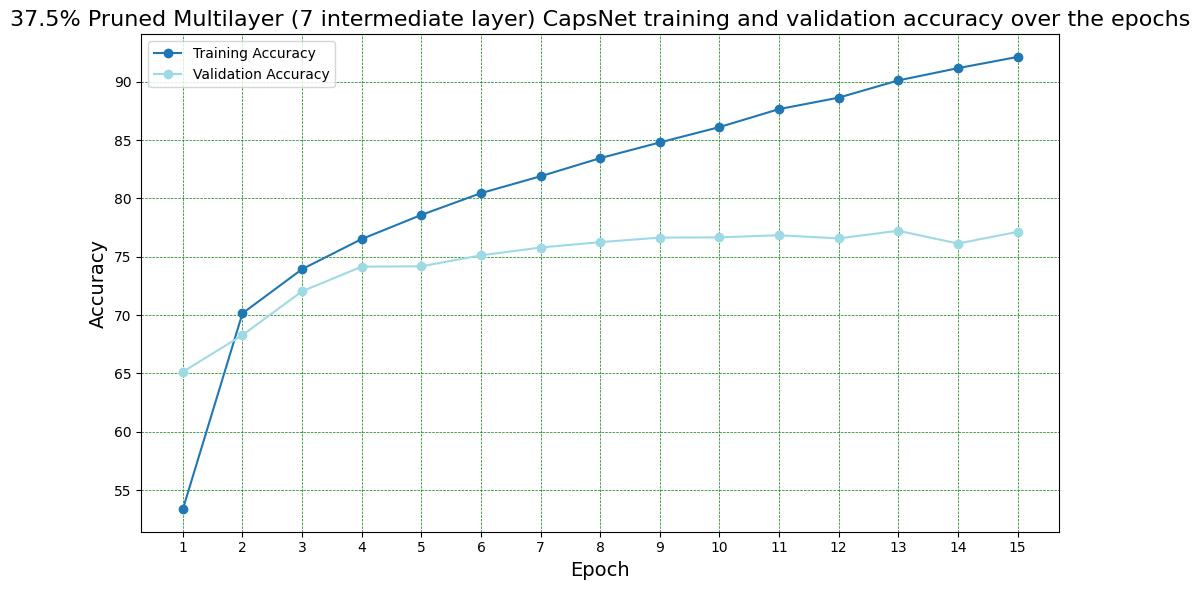

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% Pruned Multilayer (7 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 8 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter8_capsnet_cifar10_model.name = 'multilayer_inter8_capsnet_cifar10_model'
multilayer_inter8_capsnet_cifar10_model = multilayer_inter8_capsnet_cifar10_model.to(device)
multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_37pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_37pc_base_capsnet_model_state_dict = pruned_37pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_37p_multilayer_inter8_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter8_capsnet_cifar10_model,
        saved_state_dict=pruned_37pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_37p_multilayer_inter8_capsnet_cifar10_model.name = 'pruned_37p_multilayer_inter8_capsnet_cifar10_model'
pruned_37p_multilayer_inter8_capsnet_cifar10_model = pruned_37p_multilayer_inter8_capsnet_cifar10_model.to(device)
pruned_37p_multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_37p_multilayer_inter8_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/28 11:43:14 PM | pruned_37p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7150, Top 1 Acc=9.38, Top 5 Acc=56.25
INFO:capsnet:pruned_37p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7150, Top 1 Acc=9.38, Top 5 Acc=56.25
01/28 11:43:23 PM | pruned_37p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7057, Top 1 Acc=7.29, Top 5 Acc=48.96
INFO:capsnet:pruned_37p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7057, Top 1 Acc=7.29, Top 5 Acc=48.96
01/28 11:43:33 PM | pruned_37p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7013, Top 1 Acc=9.09, Top 5 Acc=50.62
INFO:capsnet:pruned_37p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7013, Top 1 Acc=9.09, Top 5 Acc=50.62
01/28 11:43:42 PM | pruned_37p_multilayer_inter8_capsnet_cifar10_model Training -

CPU times: user 1h 47min 40s, sys: 8min 28s, total: 1h 56min 9s
Wall time: 1h 55min 54s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

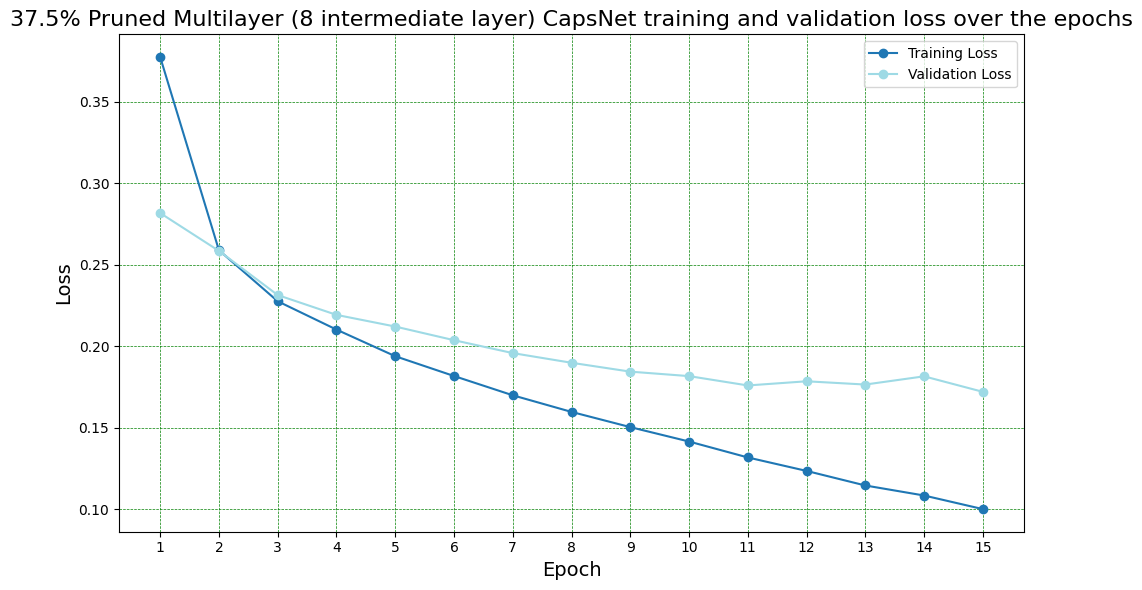

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% Pruned Multilayer (8 intermediate layer) CapsNet training and validation loss over the epochs')

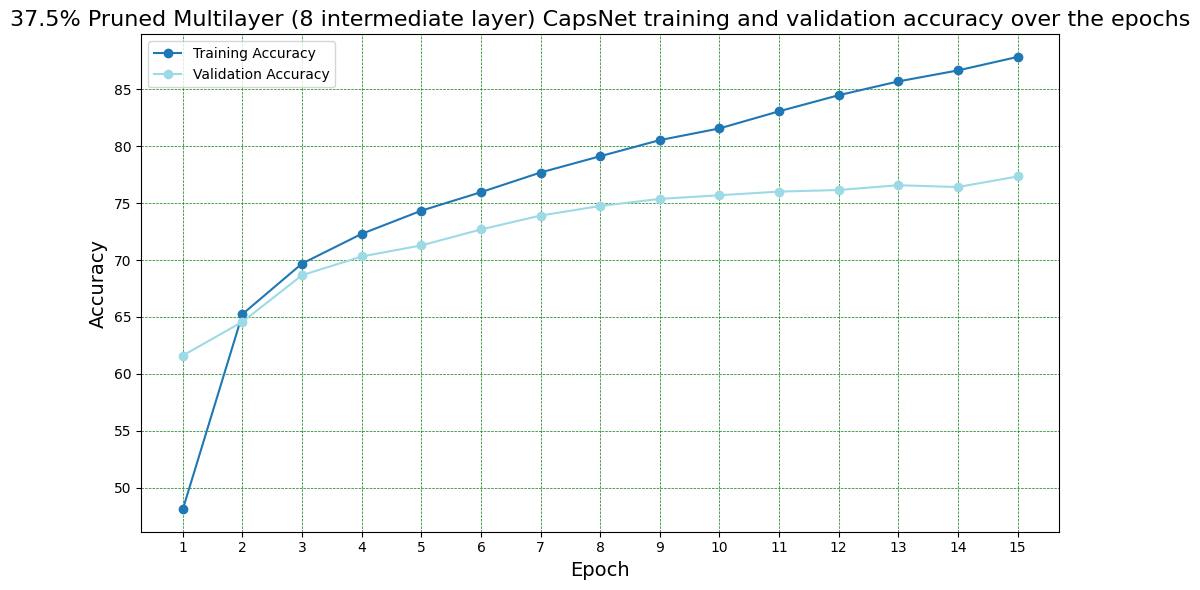

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% Pruned Multilayer (8 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 9 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=9
model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter9_capsnet_cifar10_model.name = 'multilayer_inter9_capsnet_cifar10_model'
multilayer_inter9_capsnet_cifar10_model = multilayer_inter9_capsnet_cifar10_model.to(device)
multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_37pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_37pc_base_capsnet_model_state_dict = pruned_37pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_37p_multilayer_inter9_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter9_capsnet_cifar10_model,
        saved_state_dict=pruned_37pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_37p_multilayer_inter9_capsnet_cifar10_model.name = 'pruned_37p_multilayer_inter9_capsnet_cifar10_model'
pruned_37p_multilayer_inter9_capsnet_cifar10_model=pruned_37p_multilayer_inter9_capsnet_cifar10_model.to(device)
pruned_37p_multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_37p_multilayer_inter9_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/29 01:41:03 AM | pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.6909, Top 1 Acc=15.62, Top 5 Acc=53.12
INFO:capsnet:pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.6909, Top 1 Acc=15.62, Top 5 Acc=53.12
01/29 01:41:13 AM | pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7016, Top 1 Acc=10.80, Top 5 Acc=51.70
INFO:capsnet:pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7016, Top 1 Acc=10.80, Top 5 Acc=51.70
01/29 01:41:23 AM | pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6995, Top 1 Acc=11.15, Top 5 Acc=51.63
INFO:capsnet:pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6995, Top 1 Acc=11.15, Top 5 Acc=51.63
01/29 01:41:34 AM | pruned_37p_multilayer_inter9_capsnet_cifar10_model Trai

CPU times: user 1h 59min 43s, sys: 9min 22s, total: 2h 9min 6s
Wall time: 2h 8min 49s


Checkpoint Restart

In [ ]:
%%time
n_epochs = 30
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt'

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_37p_multilayer_inter9_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device,
                                                                checkpoint_file=checkpoint_file)

Files already downloaded and verified
Files already downloaded and verified


01/29 03:59:52 AM | pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.1361, Top 1 Acc=81.25, Top 5 Acc=100.00
INFO:capsnet:pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.1361, Top 1 Acc=81.25, Top 5 Acc=100.00
01/29 04:00:03 AM | pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.1133, Top 1 Acc=85.80, Top 5 Acc=98.96
INFO:capsnet:pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.1133, Top 1 Acc=85.80, Top 5 Acc=98.96
01/29 04:00:13 AM | pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.1101, Top 1 Acc=86.06, Top 5 Acc=99.23
INFO:capsnet:pruned_37p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.1101, Top 1 Acc=86.06, Top 5 Acc=99.23
01/29 04:00:23 AM | pruned_37p_multilayer_inter9_capsnet_cifar10_mo

CPU times: user 2h 32s, sys: 9min 22s, total: 2h 9min 54s
Wall time: 2h 9min 37s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

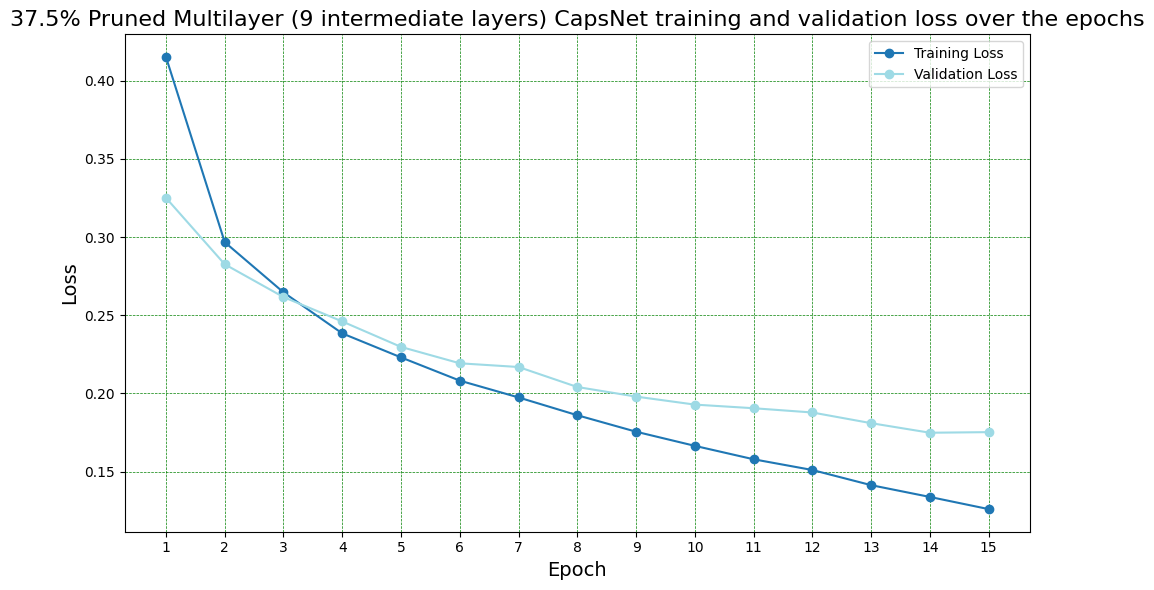

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% Pruned Multilayer (9 intermediate layers) CapsNet training and validation loss over the epochs')

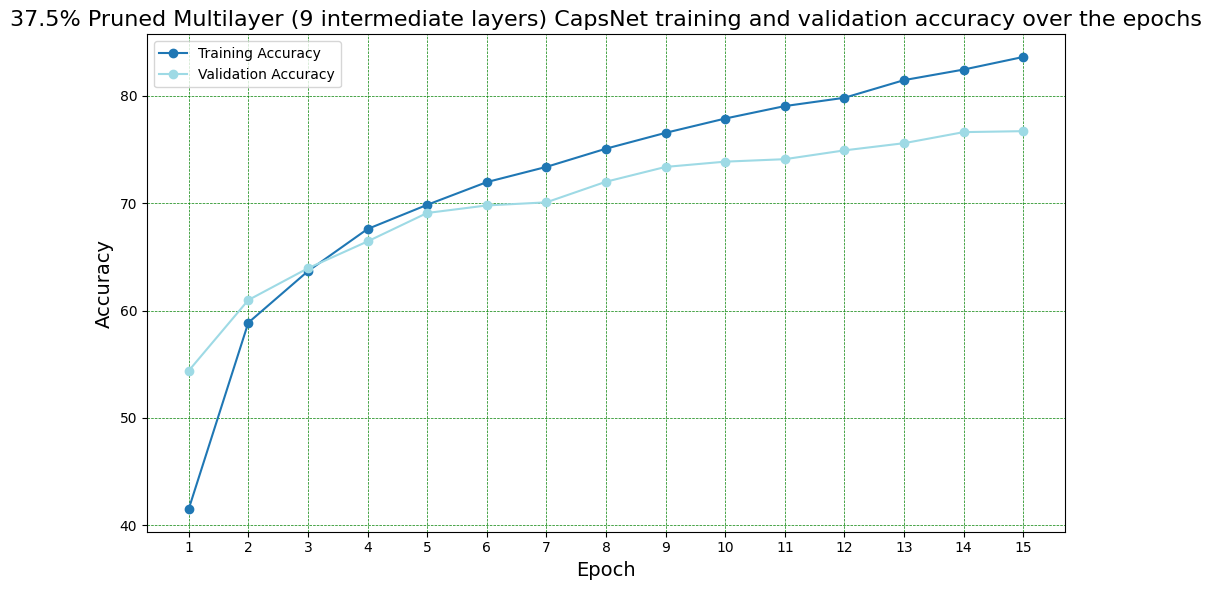

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% Pruned Multilayer (9 intermediate layers) CapsNet training and validation accuracy over the epochs')

In [ ]:
from google.colab import runtime
runtime.unassign()

## 10 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_caps_layers=10
n_class=10
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:02<00:00, 74215630.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.name = 'multilayer_inter10_capsnet_cifar10_model'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_37pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_37pc_base_capsnet_model_state_dict = pruned_37pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_37p_multilayer_inter10_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter10_capsnet_cifar10_model,
        saved_state_dict=pruned_37pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_37p_multilayer_inter10_capsnet_cifar10_model.name = 'pruned_37p_multilayer_inter10_capsnet_cifar10_model'
pruned_37p_multilayer_inter10_capsnet_cifar10_model=pruned_37p_multilayer_inter10_capsnet_cifar10_model.to(device)
pruned_37p_multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_37p_multilayer_inter10_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/26 04:33:37 PM | pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7085, Top 1 Acc=6.25, Top 5 Acc=37.50
INFO:capsnet:pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7085, Top 1 Acc=6.25, Top 5 Acc=37.50
01/26 04:33:49 PM | pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7043, Top 1 Acc=9.75, Top 5 Acc=49.81
INFO:capsnet:pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7043, Top 1 Acc=9.75, Top 5 Acc=49.81
01/26 04:34:00 PM | pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7037, Top 1 Acc=10.05, Top 5 Acc=49.52
INFO:capsnet:pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7037, Top 1 Acc=10.05, Top 5 Acc=49.52
01/26 04:34:11 PM | pruned_37p_multilayer_inter10_capsnet_cifar10_model T

CPU times: user 2h 12min 4s, sys: 10min 29s, total: 2h 22min 33s
Wall time: 2h 22min 13s


Checkpoint restart

In [ ]:
%%time
n_epochs = 30

checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt'

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_37p_multilayer_inter10_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device,
                                                                checkpoint_file=checkpoint_file)

01/26 06:56:36 PM | pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.1309, Top 1 Acc=81.25, Top 5 Acc=100.00
INFO:capsnet:pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.1309, Top 1 Acc=81.25, Top 5 Acc=100.00
01/26 06:56:47 PM | pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.1270, Top 1 Acc=83.43, Top 5 Acc=98.39
INFO:capsnet:pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.1270, Top 1 Acc=83.43, Top 5 Acc=98.39
01/26 06:56:59 PM | pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.1227, Top 1 Acc=84.33, Top 5 Acc=98.56
INFO:capsnet:pruned_37p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.1227, Top 1 Acc=84.33, Top 5 Acc=98.56
01/26 06:57:10 PM | pruned_37p_multilayer_inter10_capsnet_cif

CPU times: user 2h 12min 32s, sys: 10min 29s, total: 2h 23min 2s
Wall time: 2h 22min 40s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37p_multilayer_inter10_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

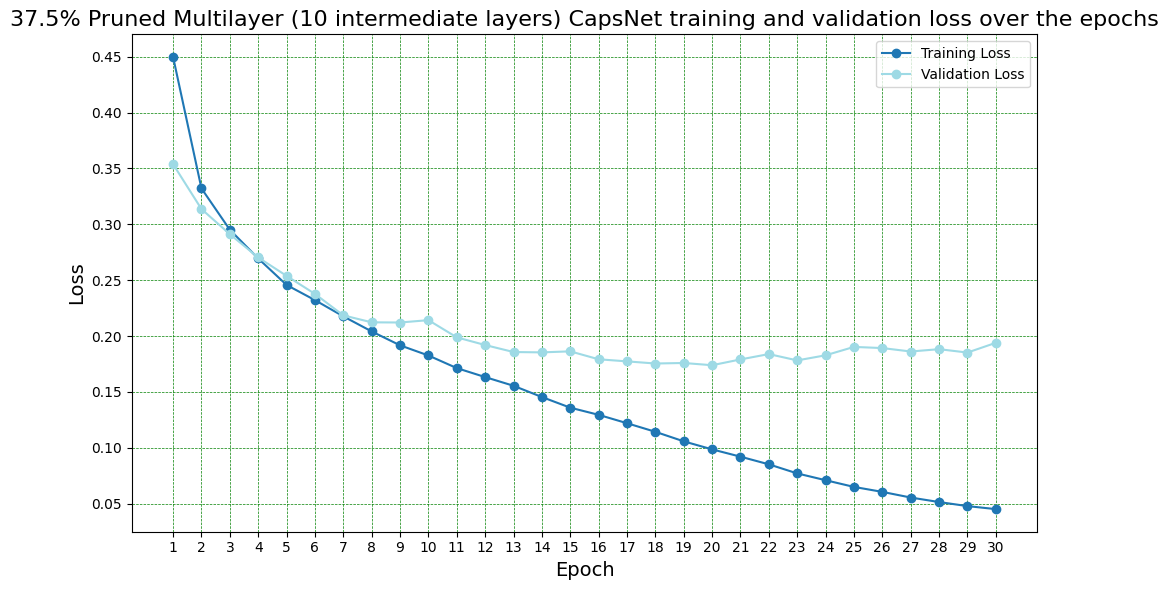

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% Pruned Multilayer (10 intermediate layers) CapsNet training and validation loss over the epochs')

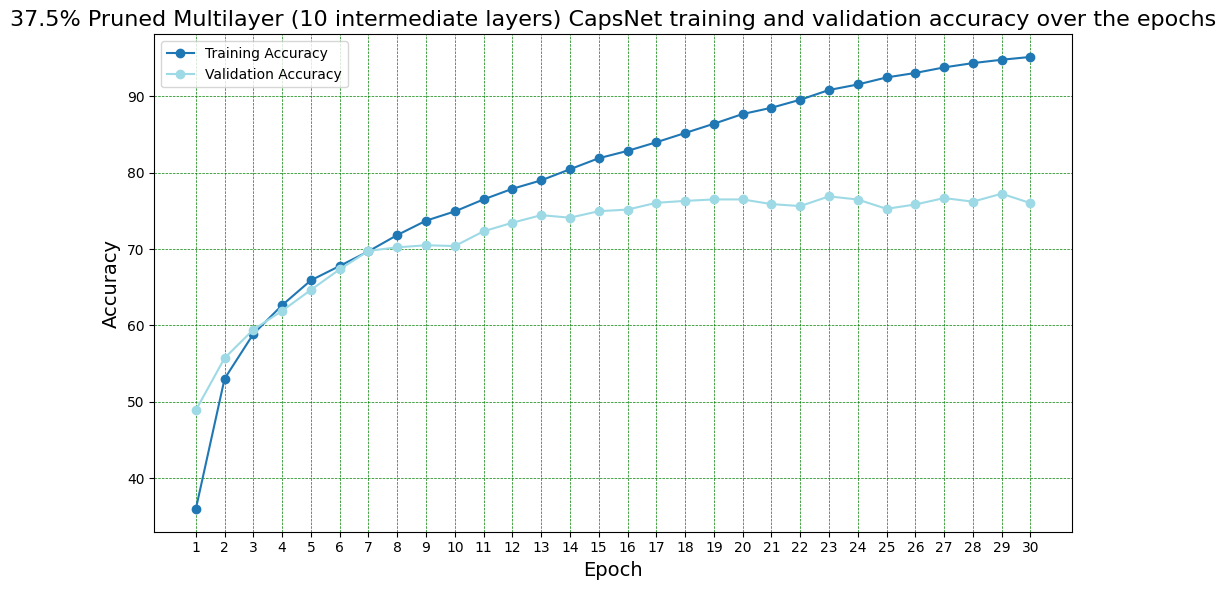

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% Pruned Multilayer (10 intermediate layers) CapsNet training and validation accuracy over the epochs')